# Action2	"AI比赛：用户购买预测

https://aistudio.baidu.com/aistudio/competition/detail/51

数据集：train.csv 训练集，submission.csv 提交数据样例

"			
"1、提交百度AI比赛（20points）

2、月榜排名前20（20points）"!

## data processing

In [2]:
import numpy as np  #
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.svm import SVR, LinearSVC
# from sklearn.pipeline import make_pipeline,Pipeline
# from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler,MinMaxScaler
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc
from datetime import date, timedelta

import random

### loading data


In [3]:
PATH = './'
train = pd.read_csv(PATH + 'train.csv')
# train = pd.read_csv('./data/data19383/train.csv', usecols=[2, 3, 4, 6, 7, 18])
# set index to ID to avoid droping it later
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv(PATH + 'submission.csv').set_index('customer_id')

In [4]:
# 训练集概况
train[['order_detail_id','order_id','order_amount','order_pay_time','is_customer_rate','order_detail_goods_num','order_detail_amount','order_detail_discount','customer_id','goods_id']].tail(10)

,order_detail_id,order_id,order_amount,order_pay_time,is_customer_rate,order_detail_goods_num,order_detail_amount,order_detail_discount,customer_id,goods_id
2306861,3685490,3238357,707.7,2013-01-24 00:24:40,0.0,2.0,179.8,298.2,2826572,1478
2306862,3685491,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,126.9,172.1,2826572,2103
2306863,3685492,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,0.0,29.9,2826572,3153
2306864,3685493,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,74.9,105.0,2826572,1778
2306865,3685494,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,94.9,104.9,2826572,2128
2306866,3685495,3238358,199.0,2013-01-10 19:24:31,0.0,1.0,59.9,139.1,2826573,1173
2306867,3685496,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,0.0,59.9,2826574,2513
2306868,3685497,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,89.9,150.0,2826574,998
2306869,3685498,3238360,168.0,2012-11-11 00:10:37,0.0,1.0,76.9,91.1,2826574,1423
2306870,3685499,3238361,102.0,2013-07-10 14:22:14,0.0,1.0,49.9,52.1,2826574,1043


In [5]:
len(test)

1585986

In [6]:
len(train['customer_id'][train.order_pay_time>'2013-07-31'].unique())

174770

In [7]:
len(train[train.order_pay_time<'2013-07-31'])

2078390

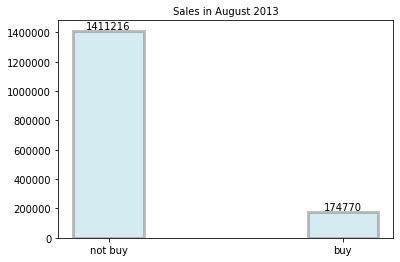

In [8]:
%matplotlib inline
y = range(1,2)
 
plt.bar(['not buy','buy'], [1585986-174770,174770], alpha=0.5, width=0.3, color='lightblue', edgecolor='grey', lw=3)
plt.title('Sales in August 2013', fontsize=10)
for a, b in zip(['not buy','buy'], [1585986-174770,174770]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

### 构造时间滑窗特征

#### 每日付款金额

In [9]:
# 将用户下单金额按天进行汇总
# df = train[train.order_status<101][train.order_pay_time>'2013-02-01']
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

/Users/Leigh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
len(df_payment['customer_id'].unique())

685471

In [11]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [12]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)
df_payment.columns = df_payment.columns.get_level_values(1)


#### 每日购买商品数量

In [13]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

In [14]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [17]:

def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [15]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i*30, 30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21,49,84]:
            tmp = get_timespan(df_goods, t2018, i, i)
            # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s' % i] = tmp.median(axis=1).values
            # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
            X['goods_max_%s' % i] = tmp.max(axis=1).values
            # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
            X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
            # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
            # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
            X['goods_max_%s_2' % i] = tmp.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018, i, i)
            X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values


    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i*28, 28).sum(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018, periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        return X
    return X

In [18]:
num_days = 4
t2017 = date(2013, 7, 1)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/Users/Leigh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/Users/Leigh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/Users/Leigh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/Users/Leigh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


In [21]:
X_train.head()

,customer_id,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,1000014,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0,49,0,0,84,0,0,0,0,0.0
1,1000034,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0,49,0,0,84,0,0,0,0,0.0
2,1000046,0.0,0.0,0.0,3.537109,39.90625,39.90625,3.537109,39.90625,39.90625,...,1,24,24,1,24,24,1,0,0,0.0
3,1000069,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0,49,0,0,84,0,0,0,0,1.0
4,1000105,0.0,0.0,0.0,0.000000,0.00000,0.00000,2.529297,98.87500,197.75000,...,1,37,37,2,37,56,0,2,0,1.0


In [22]:
customer_id = X_test["customer_id"].values.tolist()
X_train.drop(['customer_id'], inplace=True, axis=1)
X_test.drop(['customer_id'], inplace=True, axis=1)

In [23]:
X_train.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,...,0,49,0,0,84,0,0,0,0,0.0
1,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,...,0,49,0,0,84,0,0,0,0,0.0
2,0.0,0.0,0.0,3.537109,39.90625,39.90625,3.537109,39.90625,39.90625,3.537109,...,1,24,24,1,24,24,1,0,0,0.0
3,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,...,0,49,0,0,84,0,0,0,0,1.0
4,0.0,0.0,0.0,0.000000,0.00000,0.00000,2.529297,98.87500,197.75000,2.529297,...,1,37,37,2,37,56,0,2,0,1.0


In [ ]:
X_train.head()

In [24]:
print(X_train.columns)

Index(['mean_14_decay', 'max_14', 'sum_14', 'mean_30_decay', 'max_30',
       'sum_30', 'mean_60_decay', 'max_60', 'sum_60', 'mean_91_decay',
       'max_91', 'sum_91', 'mean_14_decay_2', 'max_14_2', 'mean_30_decay_2',
       'max_30_2', 'mean_60_decay_2', 'max_60_2', 'mean_91_decay_2',
       'max_91_2', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91',
       'first_has_sales_day_in_last_91', 'day_1_2018', 'day_2_2018',
       'day_3_2018', 'goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21

#### 数据归一化

In [25]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [27]:
label = X_train["label"].values.tolist()
X_train["label"] = label
X_test["label"] = 0

In [28]:
print(len(X_train.columns))

66


### 划分训练集和验证集

In [31]:
# 数据分割，在全量的训练集中划分出训练集和验证集
size = X_train.shape[0]
X_valid = X_train.iloc[int(size*0.8):]
X_train = X_train.iloc[:int(size*0.8)]
print(size,X_train.shape[0],X_valid.shape[0])

customer_id = pd.DataFrame(columns=['customer_id'],data=customer_id)
customer_id.shape

1754805 1403844 350961


(685471, 1)

In [50]:
X_test.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000194,0.00283,0.00283,0.000194,0.002830,0.002571,1.938637e-04,...,0.05,0.583333,0.591837,0.028571,0.337349,0.345238,0.0,0.003333,0.0,0
1,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,...,0.00,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0
2,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.848775e-07,...,0.00,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0
3,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000127,0.016894,0.015346,1.265033e-04,...,0.00,1.000000,0.000000,0.028571,0.590361,0.595238,0.0,0.043333,0.0,0
4,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000073,0.004184,0.003801,7.282051e-05,...,0.05,0.854167,0.857143,0.028571,0.493976,0.500000,0.0,0.003333,0.0,0


In [45]:
from sklearn import set_config
accuracy_list= {}
recall_list = {}
auc_list = {}
f1_list  = {}

set_config(print_changed_only=True)

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, confusion_matrix
def model_stats(model, x_train, x_test, y_train, y_test, x_real_test, name=''):
    model= model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    auc = roc_auc_score(y_pred, y_test)
    f1= f1_score(y_pred, y_test)
    confusion = confusion_matrix(y_pred, y_test)
    
    accuracy_list[name,model] = accuracy
    recall_list[name,model] = recall
    auc_list[name,model] = auc
    f1_list[name,model] = f1
    
    
    print('Model used:' ,model)
    print('{} accuracy: {}%'.format(name, accuracy*100))
    print('{} recall: {}%'.format(name, recall*100))
    #print('{} AUC: {}%'.format(name, auc*100))
    print('{} F1 Score: {}%'.format(name, f1*100))
    print('{} Confusion Matrix:\n{}'.format(name, confusion))
    
    pred = model.predict(x_real_test)
    
    return pred

In [51]:
import xgboost as xgb
model = xgb.XGBClassifier()

y_pred = model_stats(model, X_train.iloc[:,:-1], X_valid.iloc[:,:-1], X_train.iloc[:,-1], X_valid.iloc[:,-1], X_test.iloc[:,:-1], name='')

X_test.label = y_pred
X_test.label.value_counts()

Model used: XGBClassifier()
 accuracy: 82.12393969700337%
 recall: 66.66666666666666%
 F1 Score: 0.02549638270070434%
 Confusion Matrix:
[[288215  62734]
 [     4      8]]


0.0    684922
1.0       549
Name: label, dtype: int64

In [57]:
y_pred = pd.DataFrame(y_pred)
y_pred.value_counts()

0.0    684922
1.0       549
dtype: int64

In [56]:
submission = pd.concat([customer_id, y_pred], axis=1)
submission.head()

,customer_id,0
0,1000014,0.0
1,1000034,0.0
2,1000046,0.0
3,1000069,0.0
4,1000105,0.0
